# 数据准备

In [25]:
import os  
import torch  
import pandas as pd  
import matplotlib.pyplot as plt
  
    #step1:加载数据集
# 设置数据集的路径  
data_dir = '../../DataFiles/ODS/strain'   
# 创建空的列表来存储所有的DataFrame  
X_data0 = []  
y_data0 = []
# 遍历指定目录下的所有文件  
for filename in os.listdir(data_dir):  
    if filename.endswith('.csv'):  
        # 构建文件的完整路径  
        file_path = os.path.join(data_dir, filename)  
        # 读取Excel文件  
        df = pd.read_csv(file_path)
        serie=df.iloc[:, 0]
        version_without_extension = filename.rsplit(".", 1)[0] 
        serie.name=version_without_extension
        # 将读取的DataFrame添加到列表中  
        X_data0.append(serie)
        y_data0.append(version_without_extension)

    #step2:遍历X_data0中的每个DataFrame，并删除非数字数据  
cleaned_data = []  
for df in X_data0:  
    df_cleaned = df[pd.to_numeric(df, errors='coerce').notnull()]  
    cleaned_data.append(df_cleaned)  
 

    #step3:将X_data0中的每个DataFrame的所有元素变为float类型 
for i, df in enumerate(cleaned_data):  
    X_data0[i] = df.astype(float) 

# 初始化X_data1来存储结果  
X_data1 = []  
  
# 遍历X_data0中的每个Series  
for series in X_data0:  
    # 计算步长（由于重叠率为50%，步长为序列长度的一半）  
    step_size = 1024  # 因为2048的一半是1024，且我们想要50%的重叠  
    # 初始化一个空的list来存储子序列  
    subsequences = []  
    # 使用range和步长来生成子序列  
    for i in range(0, len(series) - 2048+ 1, step_size):  
        # 确保切片是一维的，并转换为Series（虽然这里切片已经是Series）  
        subsequence = series.iloc[i:i+2048]  
        subsequences.append(subsequence) 
    X_data1.append(subsequences)  
print((type(X_data1),len(X_data1),len(X_data1[0])))

import pandas as pd  
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder  
from keras.utils import to_categorical
import time  
from keras.callbacks import Callback  
import torch 

# 假设 X_data1 已经定义好了  
all_data = []  
all_labels = []  
  
for sublist in X_data1:  
    for series in sublist:  
        # 假设每个series是pandas Series  
        all_data.append(series.values)  
        all_labels.append(series.name)  
  
# 将数据转换为numpy数组  
data_array = np.array(all_data)  
# 将标签转换为编码  

label_encoder = LabelEncoder()  
labels_encoded = label_encoder.fit_transform(all_labels)  
  
# 如果需要one-hot编码  
labels_one_hot = to_categorical(labels_encoded)  
  
# 这里你可能需要reshape data_array 以符合LSTM的输入要求  
# LSTM通常要求输入形状为 (samples, time_steps, features)  
# 假设每个series的长度相同，或者你可以填充/截断它们以具有相同的长度  
# time_steps = data_array.shape[1]  # 假设所有series长度相同  
# data_array = data_array.reshape(-1, time_steps, 1)  # 增加一个维度以匹配LSTM的输入要求

# 分割数据集  
X_train, X_temp, y_train, y_temp = train_test_split(data_array, labels_one_hot, test_size=0.3, random_state=42)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print((type(X_train),X_train.shape,type(y_train),y_train.shape))
X_train_first_12 = X_train[:12]  

(<class 'list'>, 2, 1814)
(<class 'numpy.ndarray'>, (2412, 2048), <class 'numpy.ndarray'>, (2412, 2))


# 短时傅里叶变换(STFT)的实现和效果展示
- 我的个人理解：[傅里叶变换(FT)](./FT.md)；

## step1:设置STFT的函数

In [26]:
import numpy as np
def stft(x, window_size, hop_size, n_fft):
    n_segments = (len(x) - window_size) // hop_size + 1
    window = np.hanning(window_size)
    Zxx = np.zeros((n_fft // 2 + 1, n_segments), dtype=complex)
    for i in range(n_segments):
        start_idx = i * hop_size
        end_idx = start_idx + window_size
        segment = x[start_idx:end_idx] * window
        spectrum = np.fft.rfft(segment, n=n_fft)
        Zxx[:, i] = spectrum
    return Zxx

def istft(Zxx, window_size, hop_size, n_fft):
    n_segments = Zxx.shape[1]
    x_reconstructed = np.zeros(n_segments * hop_size + window_size)
    window = np.hanning(window_size)
    normalization = np.zeros_like(x_reconstructed)
    for i in range(n_segments):
        start_idx = i * hop_size
        end_idx = start_idx + window_size
        segment = np.fft.irfft(Zxx[:, i], n=n_fft)
        x_reconstructed[start_idx:end_idx] += segment[:window_size] * window
        normalization[start_idx:end_idx] += window ** 2
    normalization[normalization == 0] = 1e-8
    x_reconstructed /= normalization
    return x_reconstructed

def reconstruct_signal_from_components(components, window_size, hop_size, n_fft, original_length):
    reconstructed_signal = np.zeros(components[0].shape[1] * hop_size + window_size)
    for Zxx_component in components:
        reconstructed_signal += istft(Zxx_component, window_size, hop_size, n_fft)
    return reconstructed_signal[:original_length]

## step2:对原始信号进行STFT操作，获得投影系数向量组(频率幅值向量组)；

In [27]:
import numpy as np
import pandas as pd

# 假设你已经有一个信号
signal = X_train_first_12[0]  # 将长度为2048的信号替换为你的信号

# STFT参数
window_size = 128
hop_size = 64
n_fft = 128

# 使用STFT对信号进行转换获得频谱
Zxx =stft(signal, window_size, hop_size, n_fft)

# 分解频谱为多个频率分量
num_components = 6
components = [np.zeros_like(Zxx) for _ in range(num_components)]
component_size = Zxx.shape[0] // num_components
for i in range(num_components):
    start_idx = i * component_size
    end_idx = (i + 1) * component_size
    components[i][start_idx:end_idx, :] = Zxx[start_idx:end_idx, :]
reconstructed_signal = reconstruct_signal_from_components(components, window_size, hop_size, n_fft, len(signal))
    

# 信号重构
reconstructed_signal = reconstruct_signal_from_components(components, window_size, hop_size, n_fft, len(signal))


## step3:显示频谱图和相位图和原始信号和重构信号；

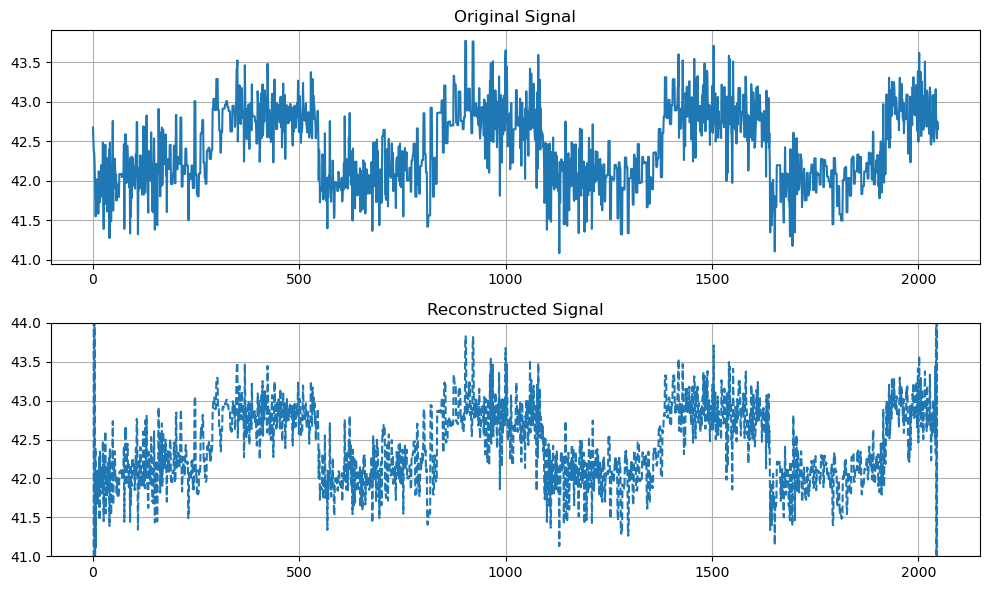

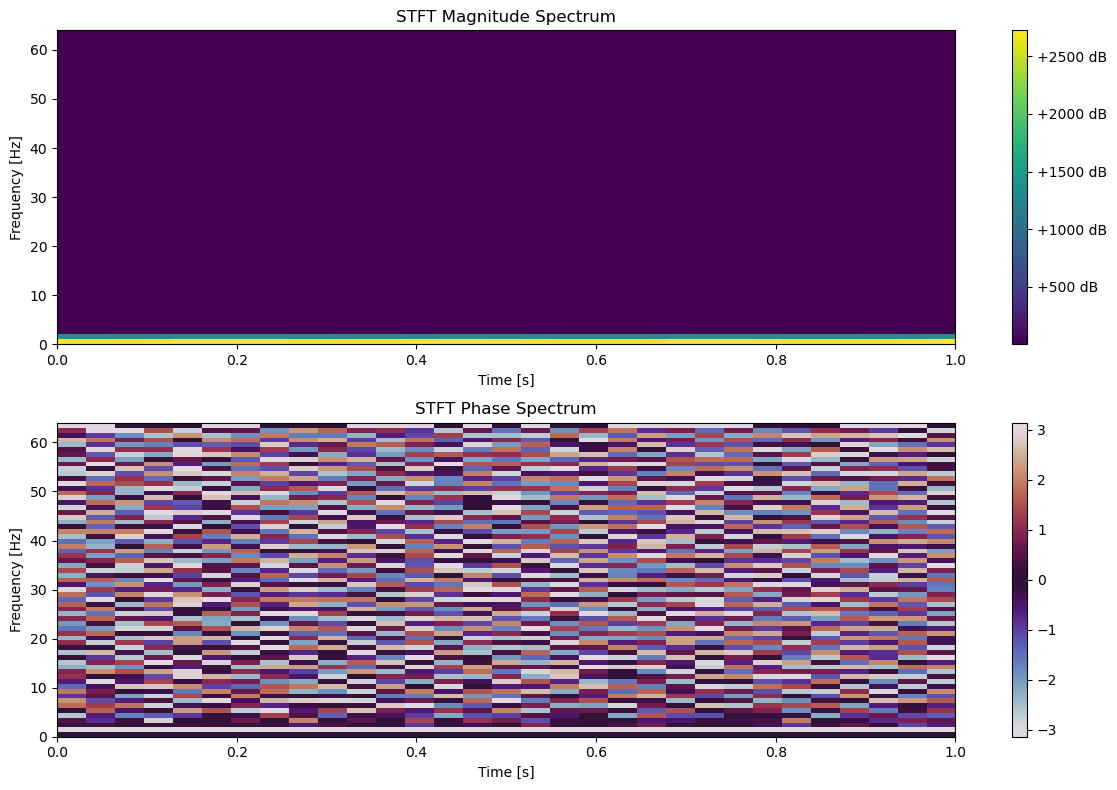

In [33]:
    # 绘制结果
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot( signal, label="Original Signal")
plt.title("Original Signal")
plt.grid(True)

    
plt.subplot(2, 1, 2)
plt.plot( reconstructed_signal, label="Reconstructed Signal", linestyle='dashed')
plt.title("Reconstructed Signal")
plt.ylim(ymin=0, ymax=100)  # 设置y轴的范围为0到1  
plt.ylim(ymin=41, ymax=44)  # 设置y轴的范围为0到1  
plt.grid(True)
    
plt.tight_layout()
plt.show()

    # 绘制频谱图
plt.figure(figsize=(12, 8))
    
plt.subplot(2, 1, 1)
plt.imshow(np.abs(Zxx), aspect='auto', origin='lower', cmap='viridis', extent=[0, 1, 0, n_fft//2])
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Magnitude Spectrum')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
    
    # 绘制相位图
plt.subplot(2, 1, 2)
plt.imshow(np.angle(Zxx), aspect='auto', origin='lower', cmap='twilight', extent=[0, 1, 0, n_fft//2])
plt.colorbar()
plt.title('STFT Phase Spectrum')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
    
plt.tight_layout()
plt.show()